<h1>目次<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#非ベイズ版の実装" data-toc-modified-id="非ベイズ版の実装-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>非ベイズ版の実装</a></span></li><li><span><a href="#ベイズ版の実装" data-toc-modified-id="ベイズ版の実装-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>ベイズ版の実装</a></span></li></ul></div>

In [1]:
using Printf

using Distributions
using QuadGK
using Roots
using StatsBase: ecdf
using StatsFuns
using StatsPlots
default(fmt=:png, size=(640, 400),
    titlefontsize=10, tickfontsize=6, guidefontsize=9,
    plot_titlefontsize=10)

safemul(x, y) = x == 0 ? x : isinf(x) ? typeof(x)(Inf) : x*y
safediv(x, y) = x == 0 ? x : isinf(y) ? zero(y) : x/y
x ⪅ y = x < y || x ≈ y

⪅ (generic function with 1 method)

## 非ベイズ版の実装

In [2]:
# odds ratio Wald

oddsratiohat(a, b, c, d) = safediv(a*d, b*c)
stderr_logoddsratiohat(a, b, c, d) = √(1/a + 1/b + 1/c + 1/d)

function pvalue_or_wald(a, b, c, d; ω=1)
    logORhat = log(oddsratiohat(a, b, c, d))
    SEhat_logORhat = stderr_logoddsratiohat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(logORhat - log(ω)), SEhat_logORhat))
end

function confint_or_wald(a, b, c, d; α=0.05)
    z = quantile(Normal(), 1-α/2)
    ORhat = oddsratiohat(a, b, c, d)
    SEhat_logORhat = stderr_logoddsratiohat(a, b, c, d)
    [safemul(exp(-z*SEhat_logORhat), ORhat), safemul(exp(z*SEhat_logORhat), ORhat)]
end

confint_or_wald (generic function with 1 method)

In [3]:
# risk ratio Wald

riskratiohat(a, b, c, d) = safediv(a*(c+d), (a+b)*c)
stderr_logriskratiohat(a, b, c, d) = √(1/a - 1/(a+b) + 1/c - 1/(c+d))

function pvalue_rr_wald(a, b, c, d; ρ=1)
    (a+b==0 || c+d==0) && return 1.0
    logRRhat = log(riskratiohat(a, b, c, d))
    SEhat_logRRhat = stderr_logriskratiohat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(logRRhat - log(ρ)), SEhat_logRRhat))
end

function confint_rr_wald(a, b, c, d; α=0.05)
    (a+b==0 || c+d==0) && return [0, Inf]
    z = quantile(Normal(), 1-α/2)
    RRhat = riskratiohat(a, b, c, d)
    SEhat_logRRhat = stderr_logriskratiohat(a, b, c, d)
    [safemul(exp(-z*SEhat_logRRhat), RRhat), safemul(exp(z*SEhat_logRRhat), RRhat)]
end

confint_rr_wald (generic function with 1 method)

In [4]:
# odds ration Pearson's χ²

function delta(a, b, c, d; ω=1)
    A, B, C = 1-ω, a+d+ω*(b+c), a*d-ω*b*c
    isinf(ω) ? typeof(ω)(-min(b, c)) : safediv(2C, B + √(B^2 - 4A*C))
end

# correction = 0.5 は連続性補正を与える.
function _chisqstat_or(a, b, c, d, δ; correction=0.0)
    ã, b̃, c̃, d̃ = a-δ, b+δ, c+δ, d-δ
    safemul(max(0, abs(δ)-correction)^2, 1/ã + 1/b̃ + 1/c̃ + 1/d̃)
end

function chisqstat_or(a, b, c, d; ω=1, correction=0.0)
    δ = delta(a, b, c, d; ω)
    _chisqstat_or(a, b, c, d, δ; correction)
end

function pvalue_or_pearson_chisq(a, b, c, d; ω=1, correction=0.0)
    χ² = chisqstat_or(a, b, c, d; ω, correction)
    ccdf(Chisq(1), χ²)
end

function confint_or_pearson_chisq(a, b, c, d; α=0.05, correction=0.0)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logω) = logit(pvalue_or_pearson_chisq(a, b, c, d; ω=exp(logω), correction)) - logit(α)
    ps = if a == 0 || d == 0
        [0, exp(find_zero(f, 0.0))]
    elseif b == 0 || c == 0
        [exp(find_zero(f, 0.0)), Inf]
    else
        ORhat = oddsratiohat(a, b, c, d)
        ω_L, ω_U = ORhat/2, 2ORhat
        [exp(find_zero(f, log(ω_L))), exp(find_zero(f, log(ω_U)))]
    end
end

confint_or_pearson_chisq (generic function with 1 method)

In [5]:
# risk ratio Pearson's χ²

function Delta(a, b, c, d; ρ=1)
    m, n = a+b, c+d
    A, B, C = ρ-1, n-a+ρ*(m-c), a*n-ρ*m*c
    isinf(ρ) ? typeof(ω)(-c) : safediv(2C, B + √(B^2 - 4A*C))
end

function _chisqstat_rr(a, b, c, d, Δ)
    m, n = a+b, c+d
    safemul(Δ^2, safediv(b, m*(a-Δ)) + safediv(d, n*(c+Δ)))
end

function chisqstat_rr(a, b, c, d; ρ=1)
    Δ = Delta(a, b, c, d; ρ)
    _chisqstat_rr(a, b, c, d, Δ)
end

function pvalue_rr_pearson_chisq(a, b, c, d; ρ=1)
    χ² = chisqstat_rr(a, b, c, d; ρ)
    ccdf(Chisq(1), χ²)
end

function confint_rr_pearson_chisq(a, b, c, d; α=0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logρ) = logit(pvalue_rr_pearson_chisq(a, b, c, d; ρ=exp(logρ))) - logit(α)
    RRhat = riskratiohat(a, b, c, d)
    if a == 0
        [0.0, exp(find_zero(f, 0.0))]
    elseif c == 0
        [exp(find_zero(f, 0.0)), Inf]
    elseif b == 0
        [0.0, exp(find_zero(f, log(2RRhat)))]
    elseif d == 0
        [exp(find_zero(f, log(RRhat/2))), Inf]
    else
        ρ_L, ρ_U = RRhat/2, 2RRhat
        [exp(find_zero(f, log(ρ_L))), exp(find_zero(f, log(ρ_U)))]
    end
end

confint_rr_pearson_chisq (generic function with 1 method)

In [6]:
# odds ratio Fisher (Clopper-Pearson)

function pvalue_or_fisher_cp(a, b, c, d; ω=1)
    fnch = if ω == 1
        Hypergeometric(a+b, c+d, a+c)
    else
        FisherNoncentralHypergeometric(a+b, c+d, a+c, ω)
    end
    min(1, 2cdf(fnch, a), 2ccdf(fnch, a-1))
end

function confint_or_fisher_cp(a, b, c, d; α = 0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(ω) = logit(pvalue_or_fisher_cp(a, b, c, d; ω)) - logit(α)
    if a == 0 || d == 0
        [0.0, find_zero(f, 1.0)]
    elseif b == 0 || c == 0
        [find_zero(f, 1.0), Inf]
    else
        ω_L, ω_U = confint_or_wald(a, b, c, d; α = α/10)
        find_zeros(f, ω_L, ω_U)
    end
end

confint_or_fisher_cp (generic function with 1 method)

In [7]:
# odds ratio Fisher (Sterne)

_pdf_le(x, (dist, y)) =  pdf(dist, x) ⪅ y

function _search_boundary(f, x0, Δx, param)
    x = x0
    if f(x, param)
        while f(x - Δx, param) x -= Δx end
    else
        x += Δx
        while !f(x, param) x += Δx end
    end
    x
end

function pvalue_sterne(dist::DiscreteUnivariateDistribution, x)
    Px = pdf(dist, x)
    Px == 0 && return Px
    Px == 1 && return Px
    m = mode(dist)
    Px ≈ pdf(dist, m) && return one(Px)
    if x < m
        y = _search_boundary(_pdf_le, 2m - x, 1, (dist, Px))
        cdf(dist, x) + ccdf(dist, y-1)
    else # x > m
        y = _search_boundary(_pdf_le, 2m - x, -1, (dist, Px))
        cdf(dist, y) + ccdf(dist, x-1)
    end
end

function pvalue_or_fisher_sterne(a, b, c, d; ω=1)
    fnch = if ω == 1
        Hypergeometric(a+b, c+d, a+c)
    else
        FisherNoncentralHypergeometric(a+b, c+d, a+c, ω)
    end
    pvalue_sterne(fnch, a)
end

function confint_or_fisher_sterne(a, b, c, d; α = 0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logω) = logit(pvalue_or_fisher_sterne(a, b, c, d; ω=exp(logω))) - logit(α)
    if a == 0 || d == 0
        [0.0, exp(find_zero(f, 0.0))]
    elseif b == 0 || c == 0
        [exp(find_zero(f, 0.0)), Inf]
    else
        ω_L, ω_U = confint_or_wald(a, b, c, d; α = α/10)
        ps = exp.(find_zeros(f, log(ω_L), log(ω_U)))
        # 次の行は稀に区間にならない場合への対策
        [first(ps), last(ps)]
    end
end

confint_or_fisher_sterne (generic function with 1 method)

In [8]:
# 警告: 以下の実装の精度は低い. 改良の仕方が
# 
# Kenneth J. Rothman, Sander Greenland, and Timothy L. Lash
# Modern Epistemology, Third Edition, 2008, 888 pages
#
# の
#
# Chapter 14. Instroduction to Categorical Statistics
# Section. Two Study Groups: Large-Sample Methods, pp.299-300
#
# に書いてある. そこでは, 次の文献が引用されている:
#
# Guangyong Zou and Allan Donner
# A simple alternative confidence interval for the difference between two proportions
# Controlled Clinical Trials, Volume 25, Issue 1, February 2004, Pages 3-12
# https://doi.org/10.1016/j.cct.2003.08.010
#
# Zou-Donnerの信頼区間に対応するP値函数の実装については
#
# https://github.com/genkuroki/public/blob/main/0033/probability%20of%20alpha%20error%20of%20Zou-Donner.ipynb
#
# を参照せよ.

riskdiffhat(a, b, c, d) = safediv(a, a+b) - safediv(c, c+d)

function stderr_riskdiffhat(a, b, c, d; u=0)
    m, n = a+b, c+d
    p̂, q̂ = safediv(a, m), safediv(c, n)
    √(safediv(p̂*(1-p̂), m-u) + safediv(q̂*(1-q̂), n-u))
end

function pvalue_rd_wald(a, b, c, d; Δ=0, u=0)
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d; u)
    2ccdf(Normal(0, 1), safediv(abs(RDhat - Δ), SEhat_riskdiffhat))
end

function confint_rd_wald(a, b, c, d; α=0.05, u=0)
    z = quantile(Normal(), 1-α/2)
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d; u)
    [RDhat - z*SEhat_riskdiffhat, RDhat + z*SEhat_riskdiffhat]
end

confint_rd_wald (generic function with 1 method)

https://github.com/genkuroki/public/blob/main/0033/probability%20of%20alpha%20error%20of%20Zou-Donner.ipynb

In [9]:
# risk difference Zou-Donner

riskdiffhat_zou_donner(a, b, c, d) = safediv(a, a+b) - safediv(c, c+d)

function stderr_riskdiffhat_zou_donner(a, b, c, d; u=1)
    m, n = a+b, c+d
    p̂, q̂ = safediv(a, m), safediv(c, n)
    √(safediv(p̂*(1-p̂), m-u) + safediv(q̂*(1-q̂), n-u))
end

function pvalue_rd_zou_donner(a, b, c, d; Δ=0, u=1)
    ((a==0 && d==0) || (b==0 && c==0)) && return 1.0
    RDhat = riskdiffhat_zou_donner(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat_zou_donner(a, b, c, d; u)
    Z = safediv((1 - RDhat^2)*abs(atanh(RDhat) - atanh(Δ)), SEhat_riskdiffhat)
    2ccdf(Normal(), abs(Z))
end

function confint_rd_zou_donner(a, b, c, d; α=0.05, u=1)
    z = quantile(Normal(), 1-α/2)
    RDhat = riskdiffhat_zou_donner(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat_zou_donner(a, b, c, d; u)
    m = atanh(RDhat)
    d = safediv(z*SEhat_riskdiffhat, 1 - RDhat^2)
    [tanh(m-d), tanh(m+d)]
end

confint_rd_zou_donner (generic function with 1 method)

## ベイズ版の実装

In [10]:
function posterior(a, b, c, d; prior=(1, 1), prior1=prior, prior2=prior)
    κ₁, λ₁ = prior1
    κ₂, λ₂ = prior1
    beta1 = Beta(κ₁+a, λ₁+b)
    beta2 = Beta(κ₂+c, λ₁+d)
    beta1, beta2
end

# 手抜き↓ これを使うとコーナーケースでおそらく失敗する.
function generic_confint(pvalue_minus_α, xmin, xmax)
    ci = find_zeros(pvalue_minus_α, xmin, xmax)
    [first(ci), last(ci)]
end

generic_confint (generic function with 1 method)

In [11]:
# risk difference Bayesian

function cdf_rd(a, b, c, d, Δ; prior=(1, 1), prior1=prior, prior2=prior)
    beta1, beta2 = posterior(a, b, c, d; prior1, prior2)
    if -1 < Δ ≤ 0
        K(q) = cdf(beta1, q+Δ)*pdf(beta2, q)
        quadgk(K, -Δ, 1)[1]
    elseif 0 < Δ < 1
        L(p) = pdf(beta1, p)*cdf(beta2, p-Δ)
        1 - quadgk(L, Δ, 1)[1]
    elseif Δ ≥ 1
        one(Δ)
    else
        zero(Δ)
    end
end

ccdf_rd(a, b, c, d, Δ; prior=(1, 1), prior1=prior, prior2=prior) =
    1 - cdf_rd(a, b, c, d, Δ; prior1, prior2)

function pdf_rd(a, b, c, d, Δ; prior=(1, 1), prior1=prior, prior2=prior)
    beta1, beta2 = posterior(a, b, c, d; prior1, prior2)
    K(q) = exp(logpdf(beta1, q+Δ) + logpdf(beta2, q))
    if -1 < Δ ≤ 0
        quadgk(K, -Δ, 1)[1]
    elseif 0 < Δ < 1
        quadgk(K, 0, 1-Δ)[1]
    else
        zero(Δ)
    end
end

# Clopper-Pearson type Bayesian P-value function

function pvalue_rd_bayes_cp(a, b, c, d; Δ=0,
        prior=(1//3, 1//3), prior1=prior, prior2=prior)
    c = cdf_rd(a, b, c, d, Δ; prior1, prior2)
    min(1, 2c, 2(1-c))
end

function confint_rd_bayes_cp(a, b, c, d; α=0.05,
        prior=(1//3, 1//3), prior1=prior, prior2=prior)
    pvalue_minus_α(Δ) = logit(pvalue_rd_bayes_cp(a, b, c, d; Δ, prior1, prior2)) - logit(α)
    xmin, xmax = confint_rd_zou_donner(a, b, c, d; α=α/10)
    generic_confint(pvalue_minus_α, xmin, xmax)
end

confint_rd_bayes_cp (generic function with 1 method)

In [12]:
# risk ratio Bayesian

function cdf_rr(a, b, c, d, ρ; prior=(1, 1), prior1=prior, prior2=prior)
    beta1, beta2 = posterior(a, b, c, d; prior1, prior2)
    if 0 < ρ ≤ 1
        K(q) = cdf(beta1, ρ*q)*pdf(beta2, q)
        quadgk(K, 0, 1)[1]
    elseif 1 < ρ < Inf
        L(p) = pdf(beta1, p)*cdf(beta2, p/ρ)
        1 - quadgk(L, 0, 1)[1]
    elseif ρ == Inf
        one(ρ)
    else
        zero(ρ)
    end
end

ccdf_rr(a, b, c, d, ρ; prior=(1, 1), prior1=prior, prior2=prior) =
    1 - cdf_rr(a, b, c, d, ρ; prior1, prior2)

function pdf_rr(a, b, c, d, ρ; prior=(1, 1), prior1=prior, prior2=prior)
    beta1, beta2 = posterior(a, b, c, d; prior1, prior2)
    K(q) = exp(log(q) + logpdf(beta1, ρ*q) + logpdf(beta2, q))
    if 0 < ρ < Inf
        quadgk(K, 0, 1)[1]
    else
        zero(ρ)
    end
end

# Clopper-Pearson type Bayesian P-value function

function pvalue_rr_bayes_cp(a, b, c, d; ρ=1,
        prior=(1//3, 1//3), prior1=prior, prior2=prior)
    c = cdf_rr(a, b, c, d, ρ; prior1, prior2)
    min(1, 2c, 2(1-c))
end

function confint_rr_bayes_cp(a, b, c, d; α=0.05,
        prior=(1//3, 1//3), prior1=prior, prior2=prior)
    pvalue_minus_α(ρ) = logit(pvalue_rr_bayes_cp(a, b, c, d; ρ, prior1, prior2)) - logit(α)
    xmin, xmax = confint_rr_wald(a, b, c, d; α=α/10)
    generic_confint(pvalue_minus_α, xmin, xmax)
end

confint_rr_bayes_cp (generic function with 1 method)

In [13]:
# odds ratio Bayesian

function cdf_or(a, b, c, d, ω; prior=(1, 1), prior1=prior, prior2=prior)
    beta1, beta2 = posterior(a, b, c, d; prior1, prior2)
    f(u) = pdf(beta1, u/(1+u))/(1+u)^2
    g(v) = pdf(beta2, v/(1+v))/(1+v)^2
    F(u) = cdf(beta1, u/(1+u))
    G(v) = cdf(beta2, v/(1+v))
    if 0 < ω ≤ 1
        K(v) = F(ω*v)*g(v)
        quadgk(K, 0, Inf)[1]
    elseif 1 < ω < Inf
        L(u) = f(u)*G(u/ω)
        1 - quadgk(L, 0, Inf)[1]
    elseif ω == Inf
        one(ω)
    else
        zero(ω)
    end
end

ccdf_or(a, b, c, d, ω; prior=(1, 1), prior1=prior, prior2=prior) =
    1 - cdf_or(a, b, c, d, ω; prior1, prior2)

function pdf_or(a, b, c, d, ω; prior=(1, 1), prior1=prior, prior2=prior)
    beta1, beta2 = posterior(a, b, c, d; prior1, prior2)
    beta1, beta2 = posterior(a, b, c, d; prior1, prior2)
    logf(u) = logpdf(beta1, u/(1+u)) - 2log(1+u)
    logg(v) = logpdf(beta2, v/(1+v)) - 2log(1+v)
    K(v) = exp(log(v) + logf(ω*v) + logg(v))
    if 0 < ω < Inf
        quadgk(K, 0, Inf)[1]
    else
        zero(ω)
    end
end

# Clopper-Pearson type Bayesian P-value function

function pvalue_or_bayes_cp(a, b, c, d; ω=1,
        prior=(1//3, 1//3), prior1=prior, prior2=prior)
    c = cdf_or(a, b, c, d, ω; prior1, prior2)
    min(1, 2c, 2(1-c))
end

function confint_or_bayes_cp(a, b, c, d; α=0.05,
        prior=(1//3, 1//3), prior1=prior, prior2=prior)
    pvalue_minus_α(ω) = logit(pvalue_or_bayes_cp(a, b, c, d; ω, prior1, prior2)) - logit(α)
    xmin, xmax = confint_or_wald(a, b, c, d; α=α/10)
    generic_confint(pvalue_minus_α, xmin, xmax)
end

confint_or_bayes_cp (generic function with 1 method)

In [14]:
using RCall

A = [
    10  6
     5 12
]
@rput A

2×2 Matrix{Int64}:
 10   6
  5  12

In [15]:
R"""prop.test(A, correct=FALSE)"""

RObject{VecSxp}

	2-sample test for equality of proportions without continuity correction

data:  A
X-squared = 3.6397, df = 1, p-value = 0.05642
alternative hypothesis: two.sided
95 percent confidence interval:
 0.009657859 0.652106847
sample estimates:
   prop 1    prop 2 
0.6250000 0.2941176 



In [16]:
@show pvalue_or_pearson_chisq(A'...)
println()
@show pvalue_rd_wald(A'...)
@show confint_rd_wald(A'...)
println()
@show pvalue_rd_zou_donner(A'...)
@show confint_rd_zou_donner(A'...)
println()
@show pvalue_rd_zou_donner(A'...; u=0)
@show confint_rd_zou_donner(A'...; u=0)
println()
@show pvalue_rd_bayes_cp(A'...)
@show confint_rd_bayes_cp(A'...)
;

pvalue_or_pearson_chisq(A'...) = 0.05641689991349114

pvalue_rd_wald(A'...) = 0.04349846732373009
confint_rd_wald(A'...) = [0.009657858984412071, 0.6521068468979409]

pvalue_rd_zou_donner(A'...) = 0.07022844714722486
confint_rd_zou_donner(A'...) = [-0.02838946175036817, 0.6144470433967624]

pvalue_rd_zou_donner(A'...; u = 0) = 0.061741515744882534
confint_rd_zou_donner(A'...; u = 0) = [-0.016896540349584505, 0.6072388586028414]

pvalue_rd_bayes_cp(A'...) = 0.05240050374464758
confint_rd_bayes_cp(A'...) = [-0.0034245809997590494, 0.6074414180091217]


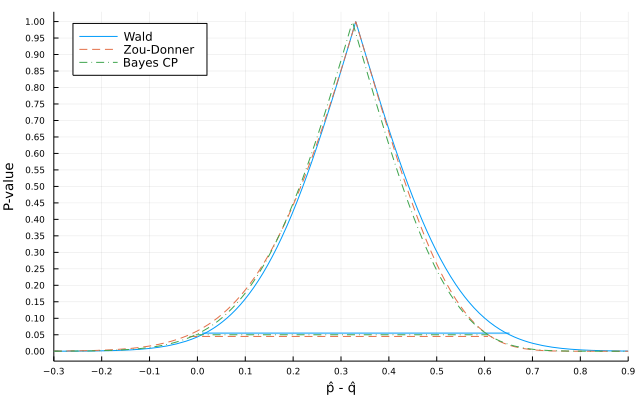

In [17]:
xlim = (-0.3, 0.9)
plot(legend=:topleft)
plot!(Δ -> pvalue_rd_wald(A'...; Δ), xlim...; label="Wald", c=1)
plot!(confint_rd_wald(A'...), fill(0.055, 2); label="", c=1)
plot!(Δ -> pvalue_rd_zou_donner(A'...; Δ, u=0), xlim...; label="Zou-Donner", ls=:dash, c=2)
plot!(confint_rd_zou_donner(A'...; u=0), fill(0.045, 2); label="", ls=:dash, c=2)
plot!(Δ -> pvalue_rd_bayes_cp(A'...; Δ), xlim...; label="Bayes CP", ls=:dashdot, c=3)
plot!(confint_rd_bayes_cp(A'...), fill(0.050, 2); label="", ls=:dashdot, c=3)
plot!(xtick=-1:0.1:1, ytick=0:0.05:1)
plot!(xguide="p̂ - q̂", yguide="P-value")
plot!(; xlim)

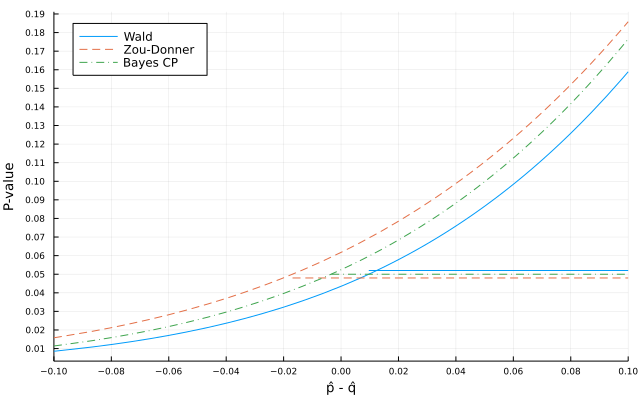

In [18]:
xlim = (-0.1, 0.1)
plot(legend=:topleft)
plot!(Δ -> pvalue_rd_wald(A'...; Δ), xlim...; label="Wald", c=1)
plot!(confint_rd_wald(A'...), fill(0.052, 2); label="", c=1)
plot!(Δ -> pvalue_rd_zou_donner(A'...; Δ, u=0), xlim...; label="Zou-Donner", ls=:dash, c=2)
plot!(confint_rd_zou_donner(A'...; u=0), fill(0.048, 2); label="", ls=:dash, c=2)
plot!(Δ -> pvalue_rd_bayes_cp(A'...; Δ), xlim...; label="Bayes CP", ls=:dashdot, c=3)
plot!(confint_rd_bayes_cp(A'...), fill(0.050, 2); label="", ls=:dashdot, c=3)
plot!(xtick=-1:0.02:1, ytick=0:0.01:1)
plot!(xguide="p̂ - q̂", yguide="P-value")
plot!(; xlim)